<a href="https://colab.research.google.com/github/DavidTitoInfantas/Prob_nao_renovacao/blob/main/Modelo_renovacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 001

In [88]:
!pip install boruta

In [89]:
import pandas as pd

### Donwload Data

In [90]:
df = pd.read_csv('/content/Asset 360 (2) (1).csv')

print('a BASE tem {} columns e {} filas'.format(df.shape[0],df.shape[1]))
print('-'*80)
df.head()

a BASE tem 43551 columns e 11 filas
--------------------------------------------------------------------------------


,cliente - id_cliente,data_inicio_vigencia_apolice,data_fim_vigencia_apolice,data_emissao_apolice,num_proposta,data_proposta,corretor - id_corretor,Departamento - id_apolice_dep,Status - ID Status Apolice,Produto - cod_produto,Cobertura - id_cobertura
0,30857552,2018-06-27,2021-05-03,2017-06-27,142694.0,2017-03-29,31475748.0,2.0,3.0,5.0,9760507.0
1,30636255,2019-10-24,2020-01-22,2018-10-24,839415.0,2018-07-26,31268581.0,4.0,5.0,1.0,8334105.0
2,30628938,2016-04-07,2016-07-06,2015-04-08,964465.0,2015-01-08,31170066.0,4.0,3.0,5.0,7081702.0
3,30651220,2019-04-04,2020-04-03,2018-04-04,928418.0,2018-01-04,31339487.0,2.0,4.0,4.0,3117073.0
4,30628064,2019-07-24,2020-07-23,2018-07-24,491721.0,2018-04-25,31343136.0,6.0,5.0,2.0,9653770.0


In [91]:
print('Procentagem de Nulls')
print('-'*80)
(df.isnull().sum()/df.shape[0])*100

Procentagem de Nulls
--------------------------------------------------------------------------------


cliente - id_cliente              0.000000
data_inicio_vigencia_apolice      0.000000
data_fim_vigencia_apolice        16.773438
data_emissao_apolice              0.002296
num_proposta                      0.002296
data_proposta                     0.002296
corretor - id_corretor            0.002296
Departamento - id_apolice_dep     0.002296
Status - ID Status Apolice        0.002296
Produto - cod_produto             0.002296
Cobertura - id_cobertura          0.002296
dtype: float64

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
df_1 = pd.read_csv('/content/Asset 360 (2)_info_pessoas.csv')

print('a BASE tem {} columns e {} filas'.format(df_1.shape[0],df_1.shape[1]))
print('-'*80)
df_1.head()

a BASE tem 35903 columns e 9 filas
--------------------------------------------------------------------------------


,Quantidade Dependentes,Escolaridade,Estado Civil,Profissão,Gênero,Data de Nascimento,Pessoa Publica,Politicamente Exposta,Cliente - id_cliente
0,0,ensino fundamental completo,solteiro,gerente de loja,Feminino,1987-07-12,False,False,30622304
1,2,ensino superior completo,casado,agente de viagem,Feminino,1987-03-25,False,False,30622305
2,5,ensino medio completo,divorciado,agente de venda de servicos as empresas,Masculino,1975-10-24,False,False,30622306
3,0,ensino superior completo,casado,tecnico de seguranca do trabalho,Masculino,1990-10-03,False,False,30622307
4,0,ensino fundamental completo,solteiro,operador de computador,Masculino,1985-06-23,False,False,30622308


In [94]:
print('Procentagem de Nulls')
print('-'*80)
(df_1.isnull().sum()/df_1.shape[0])*100

Procentagem de Nulls
--------------------------------------------------------------------------------


Quantidade Dependentes    0.000000
Escolaridade              0.005571
Estado Civil              0.005571
Profissão                 0.005571
Gênero                    0.005571
Data de Nascimento        0.005571
Pessoa Publica            0.005571
Politicamente Exposta     0.005571
Cliente - id_cliente      0.000000
dtype: float64

### Mege Tables

In [101]:
df_merge = df.merge(df_1.rename(columns={'Cliente - id_cliente':'cliente - id_cliente'}), how='inner', on='cliente - id_cliente')
df_merge.head()

,cliente - id_cliente,data_inicio_vigencia_apolice,data_fim_vigencia_apolice,data_emissao_apolice,num_proposta,data_proposta,corretor - id_corretor,Departamento - id_apolice_dep,Status - ID Status Apolice,Produto - cod_produto,Cobertura - id_cobertura,Quantidade Dependentes,Escolaridade,Estado Civil,Profissão,Gênero,Data de Nascimento,Pessoa Publica,Politicamente Exposta
0,30857552,2018-06-27,2021-05-03,2017-06-27,142694.0,2017-03-29,31475748.0,2.0,3.0,5.0,9760507.0,1,MBA,solteira,medica,feminino,1967-05-02,False,False
1,30857552,2021-05-04,2024-05-04,2021-04-04,123445.0,2021-03-11,31270582.0,3.0,1.0,32.0,10182.0,1,MBA,solteira,medica,feminino,1967-05-02,False,False
2,30636255,2019-10-24,2020-01-22,2018-10-24,839415.0,2018-07-26,31268581.0,4.0,5.0,1.0,8334105.0,0,ensino medio completo,solteiro,economistas,Masculino,1990-03-30,False,False
3,30636255,2015-03-02,2015-05-31,2014-03-02,108525.0,2013-12-02,31305504.0,4.0,5.0,4.0,9051300.0,0,ensino medio completo,solteiro,economistas,Masculino,1990-03-30,False,False
4,30628938,2016-04-07,2016-07-06,2015-04-08,964465.0,2015-01-08,31170066.0,4.0,3.0,5.0,7081702.0,3,ensino medio completo,casado,professor de psicologia,Feminino,1988-07-28,False,False


### Feature Engenieer (Encoding)

In [102]:
def funcao_limpeza(df):
  # Inferencia de Idade dos clientes
  df_training = df.copy()
  ano_atual =int(pd.to_datetime('today').normalize().strftime("%Y"))

  df_training['Idade'] = ano_atual - df_training['Data de Nascimento'].apply(lambda x: int(pd.to_datetime(x).strftime("%Y")))

  # Criação de Safras

  df_training['data_emissao_apolice'].fillna('2016-05-08',inplace=True)
  df_training['Safra'] = df_training['data_emissao_apolice'].apply(lambda x: pd.to_datetime(x).strftime("%Y-%m"))
  df_training['Escolaridade'].replace(['ensino fundamental incompleto', 'ensino fundamental completo',
                                     'ensino medio completo','ensino superior completo', 'MBA'],
                                    [0,0,1,2,3],inplace=True)

  ## Encoding Estado Civil
  df_training['Estado Civil'].replace(['solteiro', 'solteira', 'casado', 'divorciado', 'viuvo'],[0,0,1,2,3],inplace=True)

  ## Profissão não será tomada em consideração 

  ## Encoding Gênero
  df_training['Gênero'].replace(['Masculino', 'Feminino', 'feminino'],[0, 1, 1],inplace=True)

  ## Encouding Pessoa Publica
  df_training['Pessoa Publica'].replace([False,True], [0, 1],inplace=True)

  ## Encouding Politicamente Exposta
  df_training['Politicamente Exposta'].replace([False,True], [0, 1],inplace=True)

  ### Econding Target

  ## Encouding Status - ID Status Apolice
  df_training['Status - ID Status Apolice'].replace(1,'A',inplace=True)
  df_training['Status - ID Status Apolice'].replace([2,3,4,5],1,inplace=True)
  df_training['Status - ID Status Apolice'].replace('A',0,inplace=True) 

  return df_training

In [103]:
df_training = funcao_limpeza(df_merge)

### Feature Selection

In [104]:
Filtro = ['Departamento - id_apolice_dep', 
          'Produto - cod_produto', 'Quantidade Dependentes', 'Escolaridade',
          'Estado Civil','Gênero', 'Pessoa Publica', 'Politicamente Exposta',
          'Idade', 'Safra','Status - ID Status Apolice']

df_training_final = df_training[df_training['Status - ID Status Apolice'].isnull()==False][Filtro]

In [105]:
df_training_final['Status - ID Status Apolice'].value_counts(normalize=True)

1.0    0.878094
0.0    0.121906
Name: Status - ID Status Apolice, dtype: float64

In [106]:
df_training_final['Safra'].sort_values().unique()

array(['2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2021-04'], dtype=object)

In [107]:
#split data

x_training = df_training_final[~df_training_final['Safra'].isin(['2019-11', '2019-12','2021-04'])].drop(columns=['Status - ID Status Apolice','Safra'])
y_training = df_training_final[~df_training_final['Safra'].isin(['2019-11', '2019-12','2021-04'])]['Status - ID Status Apolice']

x_test = df_training_final[df_training_final['Safra'].isin(['2019-11', '2019-12','2021-04'])].drop(columns=['Status - ID Status Apolice','Safra'])
y_test = df_training_final[df_training_final['Safra'].isin(['2019-11', '2019-12','2021-04'])]['Status - ID Status Apolice']


In [108]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np
###initialize Boruta

def boruta(X,y):
  forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5)
  boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
                  )
### fit Boruta (it accepts np.array, not pd.DataFrame)
  boruta.fit(np.array(X), np.array(y))
### print results
  green_area = X.columns[boruta.support_].to_list()
  blue_area = X.columns[boruta.support_weak_].to_list()
  print('features in the green area:', green_area)
  print('='*80)
  print('features in the blue area:', blue_area)
  return green_area


In [109]:
boruta_feauter = boruta(X = x_training, y = y_training)

features in the green area: ['Departamento - id_apolice_dep']
features in the blue area: []


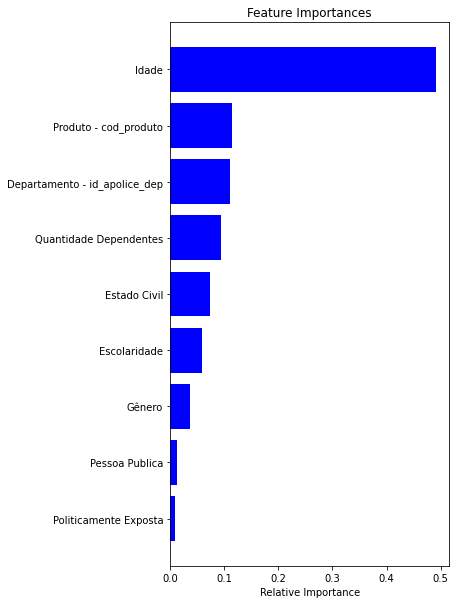

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Spliting data into test and train sets

def Feature_importances(X,y): 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
  # fitting the model
  model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  # plotting feature importances
  features = X.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)
  plt.figure(figsize=(5,10))
  plt.title('Feature Importances')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()
  a = [features[i] for i in indices]
  return pd.DataFrame({
        'Features'   : [features[i] for i in indices],
        'Importance'  : importances[indices]}).sort_values(by=['Importance'],ascending=False)

df_001 = Feature_importances(X = x_training, y = y_training)


### Training models

In [111]:
Filtro_1 = ['Departamento - id_apolice_dep','Produto - cod_produto', 'Quantidade Dependentes', 'Escolaridade',
          'Estado Civil', 'Idade']

In [112]:
#from sklearn.tree import DecisionTreeClassifier
import numpy as np

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

#import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score

scv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
def metricas(scores,target):
    return pd.DataFrame({
        'KS'   : [ks2(scores,target)],
        'ROC'  : [roc_auc_score(y_score=scores,y_true=target)],
        'GINI' : [2 * roc_auc_score(y_score=scores,y_true=target) - 1]
    })
def ks2(score, alvo):
    b2 = pd.crosstab(score, alvo, rownames = ['score']).reset_index()
    if len(np.unique(alvo)) > 1:
        freq_bom = b2.iloc[:,1]/sum(b2.iloc[:,1])
        freq_mau = b2.iloc[:,2]/sum(b2.iloc[:,2])
        ac_bom = np.cumsum(freq_bom)
        ac_mau = np.cumsum(freq_mau)
        diff = np.abs(ac_bom - ac_mau).round(7)
        ks = diff.max() * 100
    else:
        ks = 0
    return ks


In [113]:
from xgboost import XGBClassifier

def stratificated_cross_validation_XGB(x,y,num_rep=10):
  X = x
  target = y
  numero_repeticoes = num_rep
  resultados = []
  list_modelos = []
  for k in range(0,numero_repeticoes):
        metricas_cada_validacao = []
        i = 0
        skf = StratifiedKFold(n_splits=2+k, random_state=None)
        for train_index, val_index in skf.split(X,target):
            i = 1 + i
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = target.iloc[train_index], target.iloc[val_index]

            baseline = XGBClassifier(subsample=0.9, silent=False, reg_lambda=1.0
                                    ,n_estimators=100,min_child_weight=5,max_depth=15
                                   ,learning_rate=0.1,gamma=0.25,colsample_bytree=0.8, colsample_bylevel=0.6)
                        
            baseline.fit(X_train,y_train)
            #list_modelos.append(model)
            metricas_cada_validacao.append(metricas(baseline.predict_proba(X_test)[:,1],y_test))
            #print("Resultado da Validação nº",i,":",metricas(baseline.predict_proba(X_test)[:,1],y_test))
            list_modelos.append(baseline)

        resultados.append(pd.DataFrame({'Validacao '+str(k):pd.concat(metricas_cada_validacao).apply(np.mean,axis=0)}))
  return pd.concat(resultados,axis=1),list_modelos

In [114]:
resultados,modelos = stratificated_cross_validation_XGB(x_training[Filtro_1],y_training,num_rep=2)
resultados

,Validacao 0,Validacao 1
KS,32.184465,32.460827
ROC,0.673094,0.669808
GINI,0.346187,0.339615


In [115]:
def tab_modelos(list_modelos_03,X,y):
  l_ks = []
  l_roc = []
  l_gini = []
  l_modelo =[] 

  for i in range(len(list_modelos_03)): 
    #print(metricas(list_modelos_03[i].predict_proba(X[filtro])[:,0],y))
    lt = metricas(list_modelos_03[i].predict_proba(X)[:,1],y)
    l_ks.append(lt.iloc[:,0].values[0])
    l_roc.append(lt.iloc[:,1].values[0])
    l_gini.append(lt.iloc[:,2].values[0])
    n = str(i)
    l_modelo.append(n)
  
  tabela = pd.DataFrame({'Modelo' : l_modelo,'KS'  : l_ks,'ROC' : l_roc,'GINI' : l_gini})
  tabela['Estabilidade'] = 1-((tabela['KS']/100)-tabela['ROC']).abs()
  
  mod_01 = list_modelos_03[int(tabela.iloc[0,0])]
  mod_02 = list_modelos_03[int(tabela.iloc[1,0])]
  mod_03 = list_modelos_03[int(tabela.iloc[2,0])]

  return tabela.sort_values(by=['Estabilidade','ROC','KS'],ascending=False), mod_01, mod_02, mod_03 


In [116]:
tab_resultados, modelo_01, modelo_02, modelo_03 = tab_modelos(modelos,X=x_test[Filtro_1],y=y_test) 

In [117]:
tab_resultados

,Modelo,KS,ROC,GINI,Estabilidade
2,2,100.00000,1.000000,1.000000,1.000000
3,3,100.00000,1.000000,1.000000,1.000000
1,1,100.00000,1.000000,1.000000,1.000000
4,4,99.45726,0.999935,0.999869,0.994638
0,0,99.18589,0.999804,0.999608,0.992055


In [118]:
y_test.value_counts(normalize=True)

0.0    0.816168
1.0    0.183832
Name: Status - ID Status Apolice, dtype: float64

In [119]:
y_training.value_counts(normalize=True)

1.0    0.892794
0.0    0.107206
Name: Status - ID Status Apolice, dtype: float64

###Test com 70/30

In [120]:
#split data
from sklearn.model_selection import train_test_split


y_split = df_training_final['Status - ID Status Apolice']
X_split = df_training_final[Filtro_1]

X_split_train,X_split_test,y_split_train,y_split_test = train_test_split(X_split[Filtro_1],y_split,test_size=0.3)


In [121]:
resultados_split,modelos_split = stratificated_cross_validation_XGB(X_split_train[Filtro_1],y_split_train,num_rep=2)
resultados

,Validacao 0,Validacao 1
KS,32.184465,32.460827
ROC,0.673094,0.669808
GINI,0.346187,0.339615


In [122]:
tab_resultados_split, modelo_split_01, modelo_split_02, modelo_split_03 = tab_modelos(modelos_split,
                                                                                      X=X_split_test[Filtro_1],y=y_split_test)
tab_resultados_split 

,Modelo,KS,ROC,GINI,Estabilidade
3,3,27.55071,0.646904,0.293807,0.628603
4,4,27.62586,0.651782,0.303564,0.624477
2,2,27.78698,0.653987,0.307975,0.623882
1,1,27.37894,0.653121,0.306241,0.620669
0,0,27.36689,0.653468,0.306935,0.620201


In [123]:
# modelo seleccionado

modelo_split_01

XGBClassifier(colsample_bylevel=0.6, colsample_bytree=0.8, gamma=0.25,
              max_depth=15, min_child_weight=5, reg_lambda=1.0, silent=False,
              subsample=0.9)

### Scoring

In [128]:
df_scorado = df_training[df_training['Status - ID Status Apolice'].isnull()==False]

In [129]:
df_scorado["probabilidade_nao_renovacao"] = np.round(modelo_split_01.predict_proba(df_training_final[Filtro_1])[:,1],2)*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [130]:
df_scorado

,cliente - id_cliente,data_inicio_vigencia_apolice,data_fim_vigencia_apolice,data_emissao_apolice,num_proposta,data_proposta,corretor - id_corretor,Departamento - id_apolice_dep,Status - ID Status Apolice,Produto - cod_produto,Cobertura - id_cobertura,Quantidade Dependentes,Escolaridade,Estado Civil,Profissão,Gênero,Data de Nascimento,Pessoa Publica,Politicamente Exposta,Idade,Safra,probabilidade_nao_renovacao
0,30857552,2018-06-27,2021-05-03,2017-06-27,142694.0,2017-03-29,31475748.0,2.0,1.0,5.0,9760507.0,1,3,0,medica,1,1967-05-02,0,0,54,2017-06,57.0
1,30857552,2021-05-04,2024-05-04,2021-04-04,123445.0,2021-03-11,31270582.0,3.0,0.0,32.0,10182.0,1,3,0,medica,1,1967-05-02,0,0,54,2021-04,55.0
2,30636255,2019-10-24,2020-01-22,2018-10-24,839415.0,2018-07-26,31268581.0,4.0,1.0,1.0,8334105.0,0,1,0,economistas,0,1990-03-30,0,0,31,2018-10,96.0
3,30636255,2015-03-02,2015-05-31,2014-03-02,108525.0,2013-12-02,31305504.0,4.0,1.0,4.0,9051300.0,0,1,0,economistas,0,1990-03-30,0,0,31,2014-03,95.0
4,30628938,2016-04-07,2016-07-06,2015-04-08,964465.0,2015-01-08,31170066.0,4.0,1.0,5.0,7081702.0,3,1,1,professor de psicologia,1,1988-07-28,0,0,33,2015-04,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43545,30640073,2016-08-22,NaN,2015-08-23,145774.0,2015-05-25,31483607.0,5.0,1.0,2.0,3473049.0,3,0,3,assistente de vendas financeiro,1,1990-12-10,0,0,31,2015-08,99.0
43546,30627271,2017-01-17,2017-04-17,2016-01-18,914452.0,2015-10-20,30758773.0,4.0,1.0,3.0,4639524.0,0,2,2,professor de comunicacao,0,1987-08-07,0,0,34,2016-01,93.0
43547,30626903,2016-04-27,2017-04-27,2015-04-28,641962.0,2015-01-28,30997334.0,1.0,1.0,5.0,423038.0,0,0,1,agente de viagem,0,1987-10-26,0,0,34,2015-04,82.0
43548,30646352,2018-03-19,NaN,2017-03-19,692539.0,2016-12-19,31401113.0,5.0,1.0,4.0,8150313.0,0,0,1,professsor de geografia,0,1979-01-12,0,0,42,2017-03,100.0


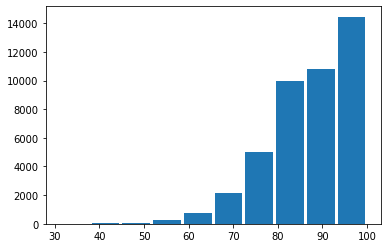

In [131]:
plt.hist(df_scorado['probabilidade_nao_renovacao'], 10, rwidth=0.9)
plt.show()

### Save model

In [ ]:
# Save Model Using joblib

import joblib

# save the model to disk
filename = 'modelo_renovacao_porto_V001.sav'
joblib.dump(modelo_split_01, filename)

In [ ]:
# load the model from disk
Modelos_001 = joblib.load('/content/modelo_renovacao_porto_V001.sav')

#result = loaded_model.score(X_test, Y_test)
#print(result)

In [ ]:
Modelos_001
